In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from lstm import LSTMNetwork
from codec import CodecTransform
from cnn import CNNNetwork
from dataset import SoundDataset
from encodec.utils import convert_audio

# Set model hyperparameters and feature hyperparameters

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
sr = 8000
num_samples = 12000
nfft=512
nmels=40
f_min=0
f_max=None

batch_size = 64
num_epochs = 150
loss = torch.nn.CrossEntropyLoss()

cuda


In [3]:
directories =  ['trimming',
 'audioMnist-pitch-up',
 'audioMinst',
 'audioMnistPitchShiftedDown',
 'jenniferMnist',
 'audioMnistNoise']

# Choose a feature to transform the data to and visualize

23753
shape of feature: torch.Size([1, 10, 47])
datatype torch.float32


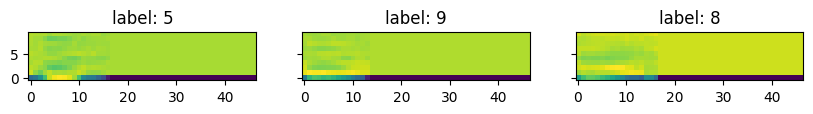

In [4]:
melSpec = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=nfft, n_mels=nmels, f_min=f_min, f_max=f_max)
mfcc = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=10, melkwargs={'n_fft':nfft, 'n_mels':nmels})
codec = CodecTransform(sample_rate=sr, bandwidth=6.0)

dataSet = SoundDataset(directories, transformation=mfcc, target_sample_rate=sr, num_samples=num_samples, device=device)
print(len(dataSet))
train_data, val_data = torch.utils.data.random_split(dataSet, (18000, 5753))
train_dl = DataLoader(train_data, batch_size=batch_size)
val_dl = DataLoader(val_data, batch_size=batch_size)
input_shape = None

fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
for i in range(3):
    img, label = val_data[i]
    if i==0:
        print('shape of feature:', img.shape)
        print('datatype', img.dtype)
        input_shape = img.shape
    axs[i].imshow(img[0].cpu(), origin='lower')
    axs[i].set_title(f'label: {label}')


# Initialize the Network

In [7]:
model = CNNNetwork(out_neurons=10, input_shape=input_shape, layers=[8, 16, 32, 64])
#model = LSTMNetwork(input_dim=8, hidden_dim=32, lstm_layers=1, linear_layers=[16, 10])

model = model.to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss = torch.nn.CrossEntropyLoss()

CNNNetwork(
  (conv_layer0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [8]:
def train_epoch(model, train_data_loader, val_data_loader, loss_fn, opt, device, metrics):

    model.train()
    losses = []
    accuracies = []
    for input, target in train_data_loader:
        input, target = input.to(device), target.to(device)

        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, target)
        _, preds = torch.max(prediction.data, 1)
        accuracies.append((preds == target).float().mean())
        losses.append(loss.item())
        # backpropagate error and update weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    metrics['t_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['t_loss'].append((sum(losses)/sum(accuracies)).cpu())
    
    model.eval()
    losses = []
    accuracies = []
    for input, target in val_data_loader:
        input, target = input.to(device), target.to(device)
        prediction = model(input)
        loss = loss_fn(prediction, target)
        _, preds = torch.max(prediction.data, 1)
        accuracies.append((preds == target).float().mean())
        losses.append(loss.item())
    
    metrics['v_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['v_loss'].append((sum(losses)/sum(accuracies)).cpu())

          

****** STARTING TRAINING ******
torch.Size([64, 1, 10, 47])
torch.Size([64, 8, 6, 24])
torch.Size([64, 16, 4, 13])
torch.Size([64, 32, 3, 7])
torch.Size([64, 64, 2, 4])
Finished epoch: 0 Val loss: 6.982275009155273
Finished epoch: 1 Val loss: 4.366379261016846
Finished epoch: 2 Val loss: 3.3139150142669678
Finished epoch: 3 Val loss: 2.779717445373535
Finished epoch: 4 Val loss: 2.5883712768554688
Finished epoch: 5 Val loss: 2.460296154022217
Finished epoch: 6 Val loss: 2.3293864727020264
Finished epoch: 7 Val loss: 2.3692708015441895
Finished epoch: 8 Val loss: 2.2334418296813965
Finished epoch: 9 Val loss: 2.271394968032837
Fininshed training
best validation accuracy tensor(0.7628)


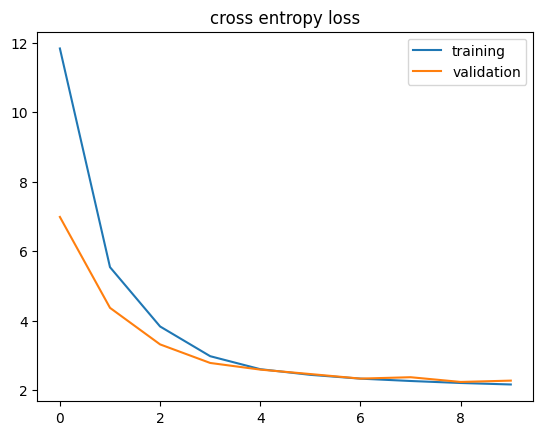

Text(0.5, 1.0, 'accuracy')

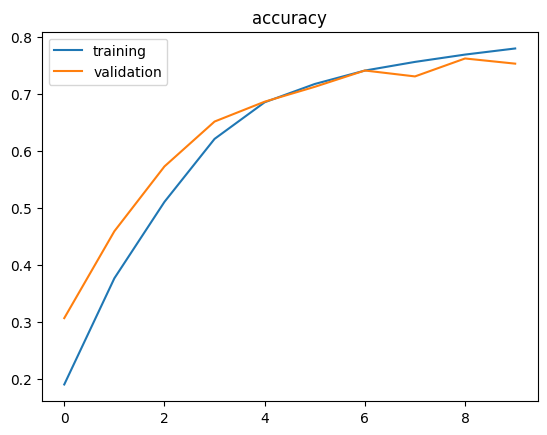

In [9]:
metrics = {
    't_loss': [],
    'v_loss': [],
    't_acc': [],
    'v_acc': []
}
print('****** STARTING TRAINING ******')
for epoch in range(10):
    train_epoch(model, train_dl, val_dl, loss_fn=loss, opt=optimizer, device=device, metrics=metrics)
    print(f"Finished epoch: {epoch} Val loss: {metrics['v_loss'][-1]}")

print("Fininshed training")    
print('best validation accuracy', max(metrics['v_acc']).data)

plt.plot(metrics['t_loss'])
plt.plot(metrics['v_loss'])
plt.legend(['training', 'validation'])
plt.title('cross entropy loss')
plt.show()

plt.figure(1)
plt.plot(metrics['t_acc'])
plt.plot(metrics['v_acc'])
plt.legend(['training', 'validation'])
plt.title('accuracy')

## Test the data on an unseen dataset, my voice

In [11]:
testDataSet = SoundDataset(['dylanMnist'], transformation=mfcc, target_sample_rate=sr, num_samples=num_samples)
testDL = DataLoader(testDataSet, batch_size=1)
correct = 0
model.eval()
for inp, target in testDL:
    inp, target = inp.to(device), target.to(device)
    prediction = model(inp)
    _, preds = torch.max(prediction.data, 1)
    if target[0] == preds[0]:
        correct += 1
    print(f'label was {target[0]}. Model classified as {preds[0]}')
    
print(f'test accuracy: {correct/10}')

label was 6. Model classified as 8
label was 4. Model classified as 4
label was 3. Model classified as 9
label was 9. Model classified as 9
label was 7. Model classified as 9
label was 2. Model classified as 0
label was 1. Model classified as 0
label was 8. Model classified as 8
label was 5. Model classified as 9
label was 0. Model classified as 0
test accuracy: 0.4
